In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
from sklearn.linear_model import LinearRegression
import json
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn import metrics
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split

2022-05-23 21:37:20.438533: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-23 21:37:20.438652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_data(data_path):
    """
    Loading of the dataset provided
    Edit the code below
    """
    with open(data_path,"r") as f:
        data = json.load(f)
    data = pd.DataFrame(data)
    data = data.drop('94')
    data = data.drop(labels=['17'], axis=0)
    return data

In [3]:
def shorten_series(data_series):
    series = np.array(data_series)
    small_series = []
    for i in range(0,len(series),10):
        if i !=0:
            small_series.append(np.mean(series[i-10:i]))
        else: 
            small_series.append(series[0])
    return np.array(small_series)


In [4]:
def preprocess_data(data):
    """
    A standard nan removal to be added.
    Add more preprocessing steps if needed.
    """
    X = []
    for i in range(data.shape[0]):
        series = np.stack((data.iloc[i]['smcAC'],data.iloc[i]['smcDC'],data.iloc[i]['vib_table'],data.iloc[i]['vib_spindle'],data.iloc[i]['AE_table'],data.iloc[i]['AE_spindle']),axis=1)
        X.append(series.reshape(9000,6))
    X = np.array(X)
    y = data['VB'].fillna(data['VB'].mean())
    return X,y

In [5]:
def split_train_test(X, y):
    """
    Splitting the data into train, test, validation 
    """
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def normalization(X_train, X_val, X_test):
    scaler = StandardScaler()
    shp = X_train.shape[1]
    X_train = np.reshape(X_train, (-1,shp))
    X_val = np.reshape(X_val, (-1,shp))
    X_test = np.reshape(X_test, (-1,shp))
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return np.reshape(X_train, (-1,shp,1)), np.reshape(X_val, (-1,shp,1)), np.reshape(X_test, (-1,shp,1))

In [7]:
def plotting(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(10,10))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('mean_squared_error')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('mean squared error loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [8]:
def timeseries_transform(data, head_size, num_heads, ff_dim, dropout=0):
    """
    Implement the timeseries transformer here
    """
    # Normalization and Attention
    x = data
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)


    res = x + data
    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Conv1D(filters=data.shape[-1], kernel_size=1)(x)
    return x + res

In [9]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
            x = timeseries_transform(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [10]:
def model_training(X_train, y_train, X_val, y_val):
    """
    Train the data with the compatible model
    """
    
    input_shape = X_train.shape[1:]
    
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        model = build_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.0)
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=10000, decay_rate=0.9)

        model.compile(
            loss="mse",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=[tensorflow.keras.metrics.MeanSquaredError()],
        )

        model.summary()

#         callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

        history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, batch_size=16)
    
    plotting(history)
    
    return model

In [11]:
def metric(y_act, y_pred):
    """
    Standard metrics and plotting should be same
    Metrics should be computed on validation data(unseen data)
    1. Balanced accuracy score
    2. Confusion matrix
    3. Per-class accuracy
    """
    
    mse = metrics.mean_squared_error(y_act, y_pred)
    
    return mse

In [12]:
def evaluate(X_test, y_act, metric, model):
    y_pred = model.predict(X_test, verbose=1)
    mse = metric(y_act, y_pred)
    
    return y_pred, mse

2022-05-23 21:37:31.671485: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-23 21:37:31.674361: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-23 21:37:31.674393: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 21:37:31.674443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1b96b70cd33c): /proc/driver/nvidia/version does not exist
2022-05-23 21:37:31.695680: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 6)]    0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 9000, 6)      27654       input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 9000, 6)      12          multi_head_attention[0][0]       
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 9000, 4)      28          layer_normalization[0][0]    

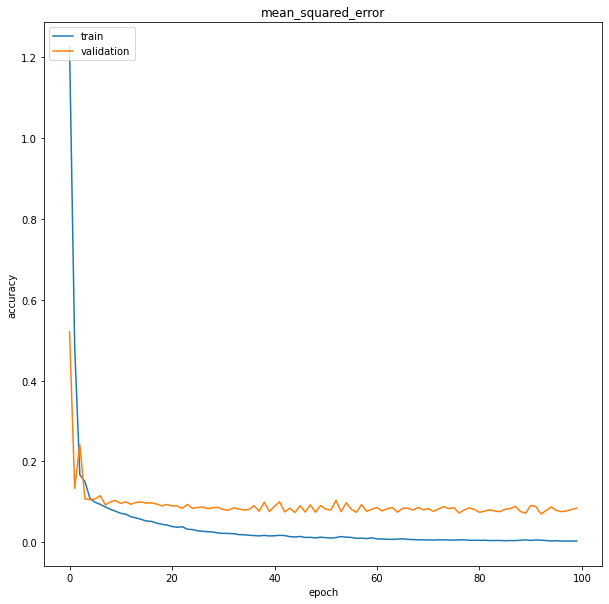

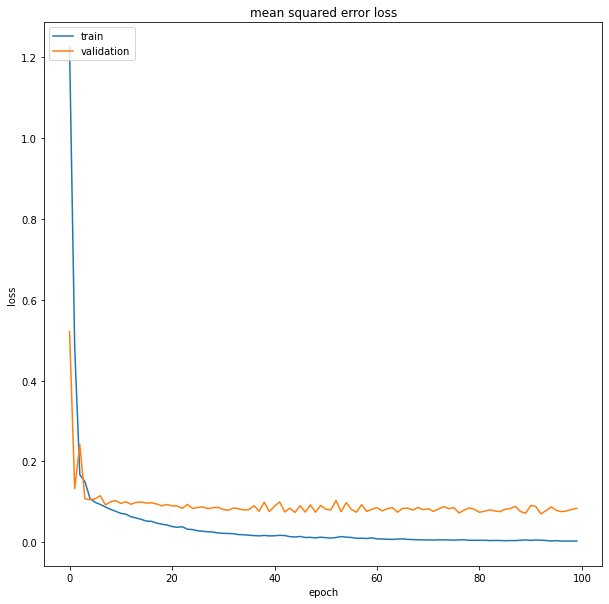

In [13]:
path = "../input/milling-dataset/ipt_12.json"
data = load_data(path)
# data['smcAC'] = data['smcAC'].apply(lambda x:shorten_series(x))
# data['smcDC'] = data['smcDC'].apply(lambda x:shorten_series(x))
# data['vib_table'] = data['vib_table'].apply(lambda x:shorten_series(x))
# data['vib_spindle'] = data['vib_spindle'].apply(lambda x:shorten_series(x))
# data['AE_table'] = data['AE_table'].apply(lambda x:shorten_series(x))
# data['AE_spindle'] = data['AE_spindle'].apply(lambda x:shorten_series(x))
X, y = preprocess_data(data)

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(X, y)

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

model_self=model_training(X_train, y_train, X_val, y_val)

In [14]:
y_pred, mse = evaluate(X_test, y_test, metric, model_self)
print(mse)

1/1 [==============================] - 3s 3s/step
0.03921875384549281


In [15]:
y_pred  = np.reshape(y_pred, y_test.shape[0])
indx = y_test.index.values
y_test_arr = y_test.to_numpy()
results = pd.DataFrame(list(zip(indx, y_test_arr, y_pred)), columns =['pos', 'y_test', 'y_pred'])
results

,pos,y_test,y_pred
0,126,0.300000,0.468942
1,92,0.680000,0.396807
2,66,0.360000,0.307863
3,111,0.290000,0.668940
4,35,0.190000,0.176936
5,132,0.100000,0.257608
6,48,0.310000,0.445164
7,108,0.650000,0.762194
8,165,0.400000,0.387394
9,42,0.360000,0.683180
